In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import torchtext
from torchtext import datasets
from torchtext import data
from torchtext.datasets import IMDB
from torchtext.vocab import Vocab
from torchtext.data import Example, Dataset

import mlxtend, torchmetrics

import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import spacy
import math
import random
from collections import defaultdict, Counter

# Models

## BiLSTM with Attention Head

In [2]:
class Model_1(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=1) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=300, #embedding dimension
                                    hidden_size=hidden_size, #hyperparameter 
                                    num_layers=2,
                                    bidirectional=True,
                                    batch_first=False,
                                    dropout=.5
                                    )
        
        self.attention_head = nn.MultiheadAttention(embed_dim=hidden_size*2, 
                                                    num_heads=1, 
                                                    batch_first=False)

        self.classifier = nn.Sequential(
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.Linear(in_features=hidden_size*2*4, out_features=hidden_size*2*4),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        nn.Linear(in_features=hidden_size*2*4, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu())

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        attention_output, attention_weights = self.attention_head(unpacked_output, unpacked_output, unpacked_output)


        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        mean_pool = torch.mean(unpacked_output, dim=0)
        max_pool, _ = torch.max(unpacked_output, dim=0)
        attention_pool = torch.mean(attention_output, dim=0)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool, attention_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

## 4 Layer Transformer

In [3]:
class Model_2_4(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=4)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

## 6 Layer Transformer

In [4]:
class Model_2_6(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=6)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

## 8 Layer Transformer

In [5]:
class Model_2_8(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        emb_dim = emb_matrix.size(1)
        vocab_size = emb_matrix.size(0)

        # self.embedding = BERTEmbeddings(emb_matrix).to(device)
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 0 to not affect gradient
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                      d_model=768, #hidden size H in paper
                                                      nhead =12,  # attention heads (768/12=64 per head)
                                                      dim_feedforward=1536, #~4*H
                                                      activation="gelu",
                                                      batch_first=True,
                                                      norm_first=True

        )

        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=8)

        #classification head
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(768, 1)

        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        hidden_states = self.transformer(word_embedding)

        cls_embedding = hidden_states[:,0,:]

        res = self.fc(self.dropout(cls_embedding)).squeeze(1)

        return res

## Combinining BiLSTM and Transformer

In [6]:
class Model_1_WordPiece(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=0) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=768, #embedding dimension
                                    hidden_size=hidden_size, #hyperparameter 
                                    num_layers=2,
                                    bidirectional=True,
                                    batch_first=True,
                                    dropout=.5
                                    )
        
        self.attention_head = nn.MultiheadAttention(embed_dim=hidden_size*2, 
                                                    num_heads=1, 
                                                    batch_first=True)

        self.classifier = nn.Sequential(
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.Linear(in_features=hidden_size*2*4, out_features=hidden_size*2*4),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        nn.Linear(in_features=hidden_size*2*4, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu(),
                                                             batch_first=True)

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        attention_output, attention_weights = self.attention_head(unpacked_output, unpacked_output, unpacked_output)


        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        mean_pool = torch.mean(unpacked_output, dim=1)
        max_pool, _ = torch.max(unpacked_output, dim=1)
        attention_pool = torch.mean(attention_output, dim=1)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool, attention_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

In [7]:
class Model_3(nn.Module):    
    def __init__(self, emb_matrix, hidden_size=256):
        super().__init__()
        self.model1 = Model_1_WordPiece(emb_matrix, hidden_size)
        self.model2 = Model_2_4(emb_matrix)

        # Replace their final classifiers with "feature extractors"
        self.model1.classifier = nn.Identity()
        self.model2.fc = nn.Identity()

        # Joint classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*2*4 + 768, 512),  # concat Model1 feats + Model2 feats
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 1)
        )

    def forward(self, input_indices, input_lengths):
        feats1 = self.model1(input_indices, input_lengths)  # [batch, hidden*2*4]
        feats2 = self.model2(input_indices, input_lengths)  # [batch, 768]

        combined_feats = torch.cat([feats1, feats2], dim=1)
        res = self.classifier(combined_feats).squeeze(1)

        return res

# Loading in Data

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## No Chunking (spacy)

In [9]:
nlp = spacy.load("en_core_web_lg")

#need to create this function to tokenize since i am using an old torchtext version 0.6.0
def tokenize_fn(text):
    return [token.text for token in nlp.tokenizer(text)]

In [10]:
train_text_field = data.Field(sequential=True, lower=True, tokenize=tokenize_fn, include_lengths=True)
train_label_field = data.Field(sequential=False, use_vocab=True, unk_token=None)

In [11]:
train_dataset, test_dataset = datasets.IMDB.splits(
    text_field=train_text_field,
    label_field=train_label_field
)


train_dataset, validation_dataset = train_dataset.split(
                                                        split_ratio=0.8,
                                                        random_state=random.seed(43)
)

In [12]:
train_text_field.build_vocab(train_dataset)
train_label_field.build_vocab(train_dataset)

In [13]:
BATCH_SIZE = 32

train_iter = data.BucketIterator(
                                 dataset=train_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

validation_iter = data.BucketIterator(
                                 dataset=validation_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

test_iter = data.BucketIterator(
                                 dataset=test_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

### Creating Embedding Matrix

In [14]:
emb_dim = nlp.vocab.vectors_length
vocab_size = len(train_text_field.vocab)

embedding_matrix = torch.empty((vocab_size,emb_dim))
#map indices from torchtext to spacy
for index, token in enumerate(train_text_field.vocab.itos):
    embedding_matrix[index] = torch.tensor(nlp.vocab[token].vector, device=device, dtype=torch.float)

embedding_matrix.shape

torch.Size([90636, 300])

## Chunked Dataset (WordPiece)

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(text):
    return  tokenizer.tokenize(text) 

In [16]:
chunked_train_text_field = data.Field(sequential=True,
                                tokenize=tokenize_fn,
                                lower=False,             
                                include_lengths=True,
                                use_vocab=True,
                                batch_first=True,        # helpful later for BERT models
                                pad_token=tokenizer.pad_token,
                                unk_token=tokenizer.unk_token,
                                init_token=tokenizer.cls_token,  # add [CLS] at start
                                eos_token=tokenizer.sep_token    # add [SEP] at end
                                )

chunked_train_label_field = data.Field(sequential=False, use_vocab=True, unk_token=None)

chunked_review_id_field = data.Field(sequential=False, use_vocab=False, unk_token=None)

In [17]:
# Load IMDB dataset
chunked_train_dataset, chunked_test_dataset = datasets.IMDB.splits(
    text_field=chunked_train_text_field,
    label_field=chunked_train_label_field
)


chunked_train_dataset, chunked_validation_dataset = chunked_train_dataset.split(
                                                        split_ratio=0.8,
                                                        random_state=random.seed(43)
)

In [18]:
chunked_train_text_field.build_vocab(chunked_train_dataset, 
                             vectors=None,  # we’ll replace this with BERT vocab later if needed
                             max_size=30000)

chunked_train_label_field.build_vocab(chunked_train_dataset)

In [19]:
# Create dummy counter since BERT vocab is prebuilt
dummy_counter = Counter()

# Initialize Vocab
chunked_train_text_field.vocab = Vocab(dummy_counter, specials=[])

# Load HuggingFace vocab
bert_vocab = tokenizer.get_vocab()  # dict: token → id

# Replace stoi and itos
chunked_train_text_field.vocab.stoi = bert_vocab
chunked_train_text_field.vocab.itos = {i: s for s, i in bert_vocab.items()}

In [20]:
def chunk_dataset(original_dataset, max_len=512):
    all_examples = []

    for review_idx, example in enumerate(original_dataset):
        tokens = example.text  # already tokenized

        chunk_len = max_len - 2  # leave room for [CLS] and [SEP]
        
        # split into chunks
        for i in range(0, len(tokens), chunk_len):
            chunk_tokens = tokens[i:i + chunk_len]

            # add special tokens for every chunk
            # chunk_tokens = [original_dataset.fields['text'].init_token] + chunk_tokens + [original_dataset.fields['text'].eos_token]
            chunk_tokens =  chunk_tokens 

            # create a new Example with review_id field
            new_example = Example.fromlist(
                [chunk_tokens, example.label, review_idx],
                fields=[('text', original_dataset.fields['text']),
                        ('label', original_dataset.fields['label']),
                        ('review_id', chunked_review_id_field)]
            )
            all_examples.append(new_example)

    # include the review_id field in the dataset
    chunked_dataset = Dataset(all_examples, fields={
        'text': original_dataset.fields['text'],
        'label': original_dataset.fields['label'],
        'review_id': chunked_review_id_field
    })

    return chunked_dataset

In [21]:
BATCH_SIZE = 32

chunked_train_dataset = chunk_dataset(chunked_train_dataset, max_len=512)
chunked_val_dataset = chunk_dataset(chunked_validation_dataset, max_len=512)
chunked_test_dataset = chunk_dataset(chunked_test_dataset, max_len=512)

In [22]:
chunked_train_iter = data.BucketIterator(
    dataset=chunked_train_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

chunked_validation_iter = data.BucketIterator(
    dataset=chunked_val_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

chunked_test_iter = data.BucketIterator(
    dataset=chunked_test_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

### Mapping embeddings

In [23]:
bert = BertModel.from_pretrained('bert-base-uncased')
vector_embedding_matrix = bert.embeddings.word_embeddings.weight.clone().detach()

# Evaluation Functions

In [24]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq gets how many values are equal, them sum, them get only the item in the tensor
  acc = (correct/len(y_pred))*100
  return acc

In [25]:
def inference_mode_chunked(model, data_iter, device=device):
    """
    Inference for models trained on chunked data. Aggregates predictions per review.
    Works with torchtext 0.6.0 and chunked datasets.
    """
    model.eval()
    review_preds = defaultdict(list)  # store probs per review
    review_labels = {}                # store true label per review

    with torch.inference_mode():
        for batch in tqdm(data_iter, desc="Inference on chunks"):
            batch_features, batch_lengths = batch.text  # features and lengths
            batch_labels = batch.label
            batch_features = batch_features.to(device)

            # forward pass
            logits = model(batch_features, batch_lengths)
            probs = torch.sigmoid(logits).cpu()  # shape: [batch_size]

            # map each chunk to its review_id
            batch_review_ids = batch.review_id.cpu()  # shape: [batch_size]
            for i in range(batch_features.size(0)):
                rid = batch_review_ids[i].item()
                review_preds[rid].append(probs[i].item())
                review_labels[rid] = batch_labels[i].item()

    # Aggregate per review
    y_true, y_pred, y_prob = [], [], []
    for rid in sorted(review_preds.keys()):
        chunk_probs = review_preds[rid]
        avg_prob = sum(chunk_probs) / len(chunk_probs)
        y_prob.append(avg_prob)
        y_pred.append(1 if avg_prob >= 0.5 else 0)
        y_true.append(review_labels[rid])

    if len(y_true) == 0:
        print("⚠️ Warning: No review predictions found. Check that review_ids are set in dataset.")
        return None, None, None

    y_true_tensor = torch.tensor(y_true)
    y_pred_tensor = torch.tensor(y_pred)
    y_prob_tensor = torch.tensor(y_prob)

    correct = (y_pred_tensor == y_true_tensor).sum().item()
    total = len(y_true_tensor)
    print(f"Correct predictions: {correct}/{total} ({correct/total:.2%})")

    return y_pred_tensor, y_true_tensor, y_prob_tensor


In [26]:
def inference_mode(model:torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               device: torch.device = device):
    y_preds=[]
    y_trues=[]
    y_probs=[]
    model.eval()

    with torch.inference_mode():
        for inference_batch in tqdm(data_iter, desc='Making predictions...'#desciption
                        ):
            inference_batch_features, inference_batch_lengths = inference_batch.text
            inference_batch_labels = inference_batch.label


            y_logit = model(inference_batch_features, inference_batch_lengths)
            y_prob = torch.sigmoid(y_logit)
            y_pred = torch.round(y_prob)

            y_probs.append(y_prob.cpu())
            y_preds.append(y_pred.cpu())
            y_trues.append(inference_batch_labels.cpu())

        # print(y_preds)
        y_pred_tensor = torch.cat(y_preds).long()
        y_true_tensor = torch.cat(y_trues).float()
        y_prob_tensor = torch.cat(y_probs).float()  # shape [25000]

        correct = (y_pred_tensor == y_true_tensor).sum().item()
        total = y_true_tensor.size(0)

        print(f"Correct predictions: {correct}/{total} ({correct/total:.2%})")

        return y_pred_tensor, y_true_tensor, y_prob_tensor

# Loading Models In

In [27]:
def load_model(model_class, model_path, *args, **kwargs):
    """
    Loads a model with the given class and checkpoint path.
    Handles checkpoints that include optimizer/scheduler info.
    """
    # initialize model
    model = model_class(*args, **kwargs)
    
    # load checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    # if checkpoint contains model_state_dict, extract it
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint  # in case it was just the raw weights
    
    model.load_state_dict(state_dict)
    model.eval()
    return model


In [28]:
models = {
    "Transformer_4Layer": load_model(Model_2_4, "Best_Transformer_4_Layer.pth", vector_embedding_matrix),
    "Transformer_6Layer": load_model(Model_2_6, "Best_Transformer_6_Layer.pth", vector_embedding_matrix),
    "Transformer_8Layer": load_model(Model_2_8, "Best_Transformer_8_Layer_Revised.pth", vector_embedding_matrix),
    "BiLSTM_Transformer": load_model(Model_3, "BILSTM_And_Transformer.pth", vector_embedding_matrix, hidden_size=256),
    "BiLSTM_Chunked": load_model(Model_1_WordPiece, "BILSTM_Chunked.pth", vector_embedding_matrix, hidden_size=256),
    "BiLSTM_256hs_Attn": load_model(Model_1, "BILSTM(256hs)_With_An_Attention_Head_2.pth", embedding_matrix, hidden_size=256),
    "BiLSTM_512hs_Attn": load_model(Model_1, "BILSTM(512hs)_With_An_Attention_Head_2.pth", embedding_matrix, hidden_size=512),
}

c:\Users\User\Projects\Own NLP Learning\model_0-env\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [29]:
# pick correct test iterator per model
test_iters = {
    "Transformer_4Layer": chunked_test_iter,
    "Transformer_6Layer": chunked_test_iter,
    "Transformer_8Layer": chunked_test_iter,
    "BiLSTM_Transformer": chunked_test_iter,
    "BiLSTM_Chunked": chunked_test_iter,
    "BiLSTM_256hs_Attn": test_iter,
    "BiLSTM_512hs_Attn": test_iter,
}

In [30]:
results = {}

for model_name, model in models.items():
    model = model.to(device)
    data_iter = test_iters[model_name]

    # Pick function based on iterator type
    if data_iter is chunked_test_iter:
        y_pred, y_true, y_prob = inference_mode_chunked(model, data_iter, device=device)
    else:
        y_pred, y_true, y_prob = inference_mode(model, data_iter, device=device)

    results[model_name] = {
        "y_pred": y_pred,
        "y_true": y_true,
        "y_prob": y_prob
    }

    print(f"{model_name} ✅ finished inference")



Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21620/25000 (86.48%)
Transformer_4Layer ✅ finished inference


Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21708/25000 (86.83%)
Transformer_6Layer ✅ finished inference


Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21602/25000 (86.41%)
Transformer_8Layer ✅ finished inference


Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 21930/25000 (87.72%)
BiLSTM_Transformer ✅ finished inference


Inference on chunks:   0%|          | 0/908 [00:00<?, ?it/s]

Correct predictions: 20777/25000 (83.11%)
BiLSTM_Chunked ✅ finished inference


Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22583/25000 (90.33%)
BiLSTM_256hs_Attn ✅ finished inference


Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22554/25000 (90.22%)
BiLSTM_512hs_Attn ✅ finished inference



🔹 Transformer_4Layer 🔹
Accuracy: 0.8648, F1 (weighted): 0.8646
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     12500
           1       0.84      0.91      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000



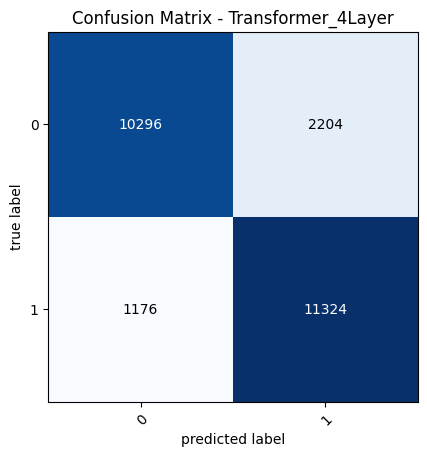

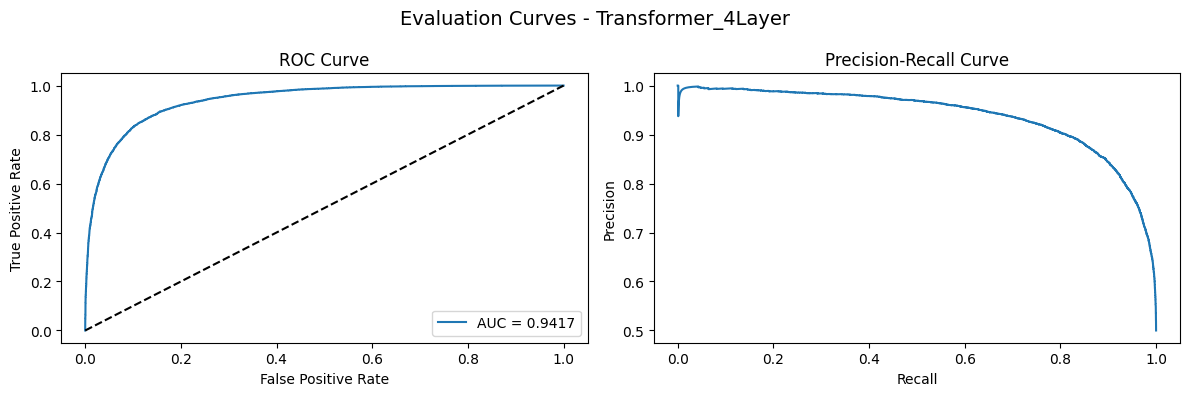


🔹 Transformer_6Layer 🔹
Accuracy: 0.8683, F1 (weighted): 0.8681
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     12500
           1       0.84      0.91      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



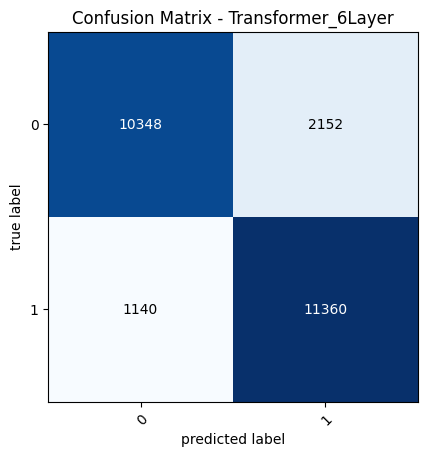

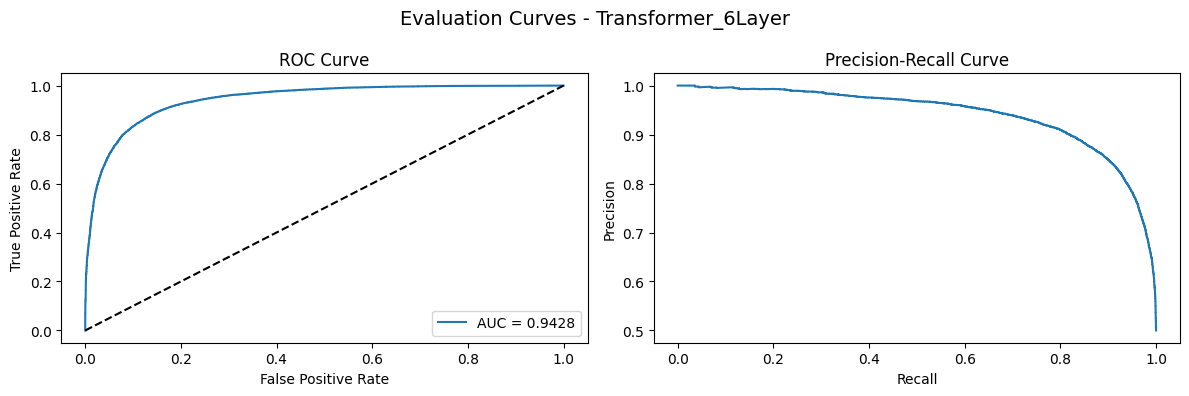


🔹 Transformer_8Layer 🔹
Accuracy: 0.8641, F1 (weighted): 0.8640
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     12500
           1       0.89      0.83      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000



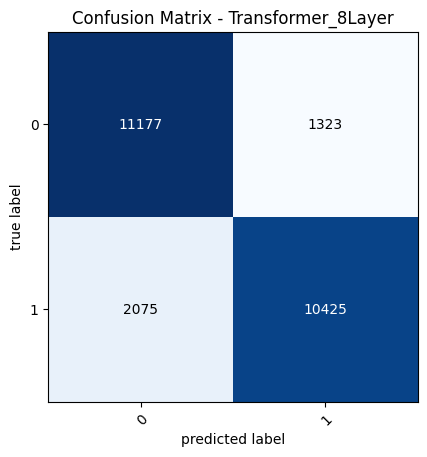

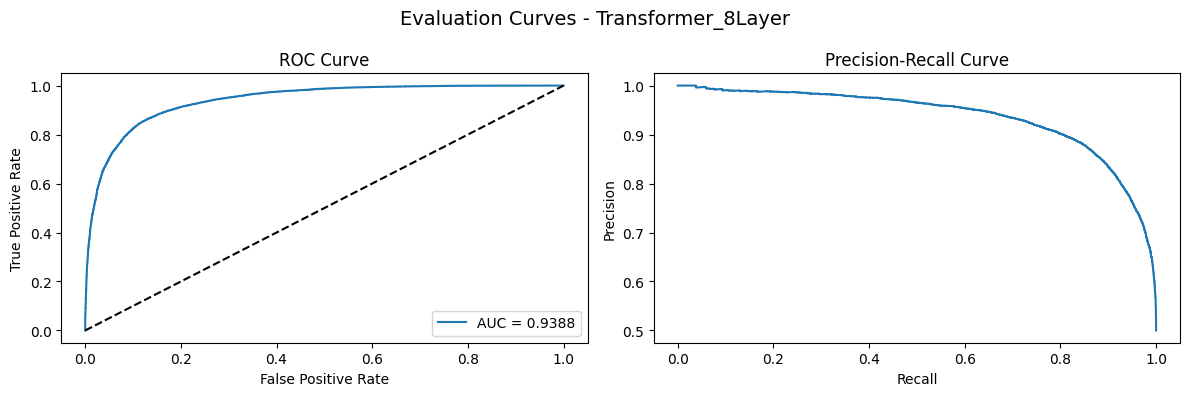


🔹 BiLSTM_Transformer 🔹
Accuracy: 0.8772, F1 (weighted): 0.8772
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.89      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



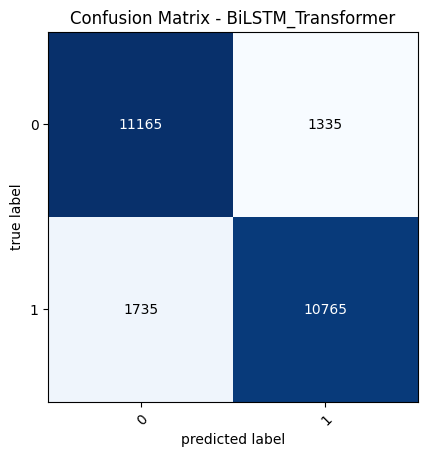

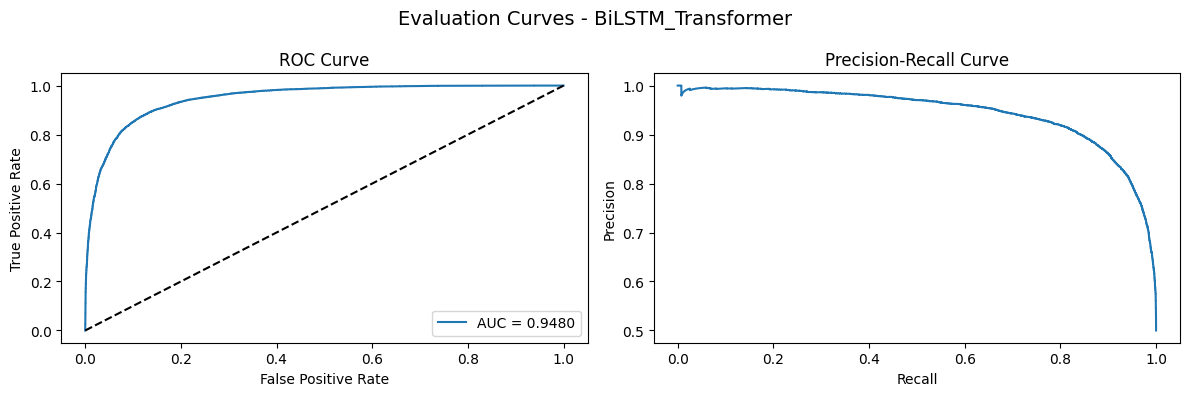


🔹 BiLSTM_Chunked 🔹
Accuracy: 0.8311, F1 (weighted): 0.8311
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



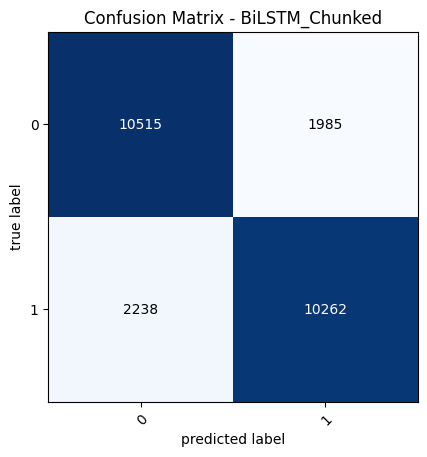

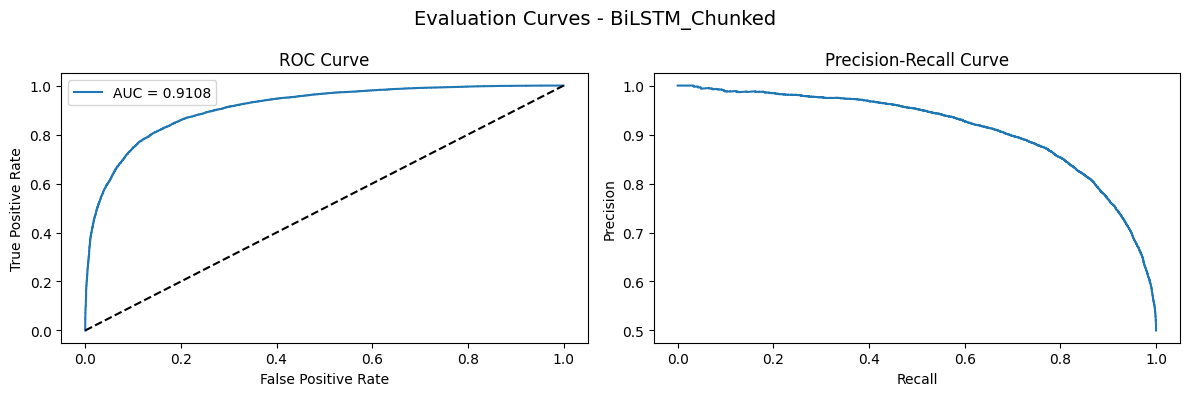


🔹 BiLSTM_256hs_Attn 🔹
Accuracy: 0.9033, F1 (weighted): 0.9033
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     12500
         1.0       0.90      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



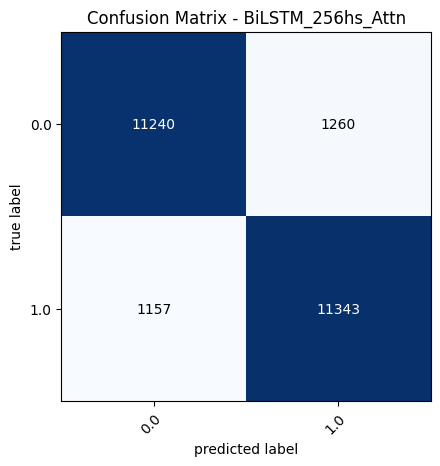

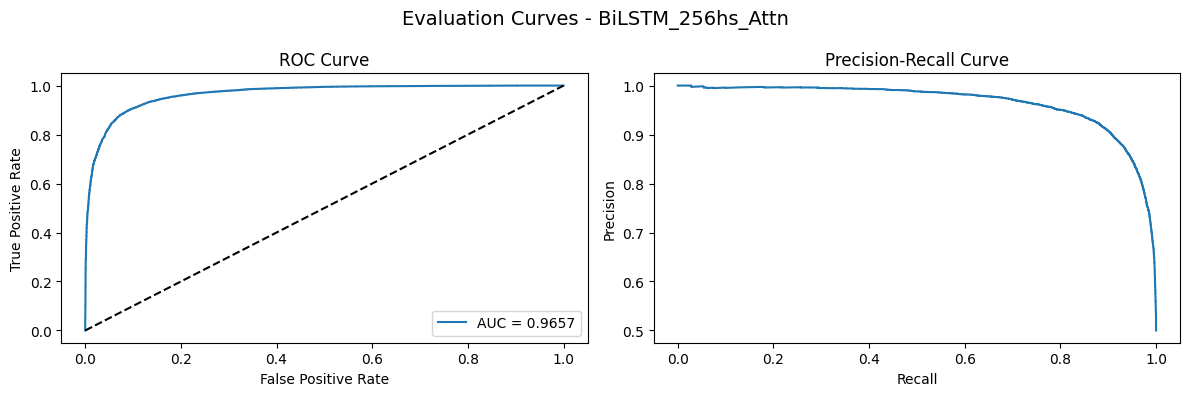


🔹 BiLSTM_512hs_Attn 🔹
Accuracy: 0.9022, F1 (weighted): 0.9021
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90     12500
         1.0       0.92      0.88      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



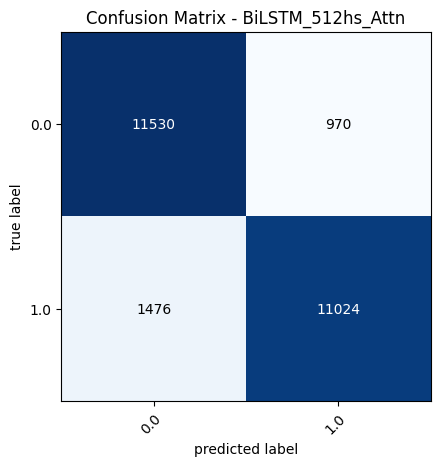

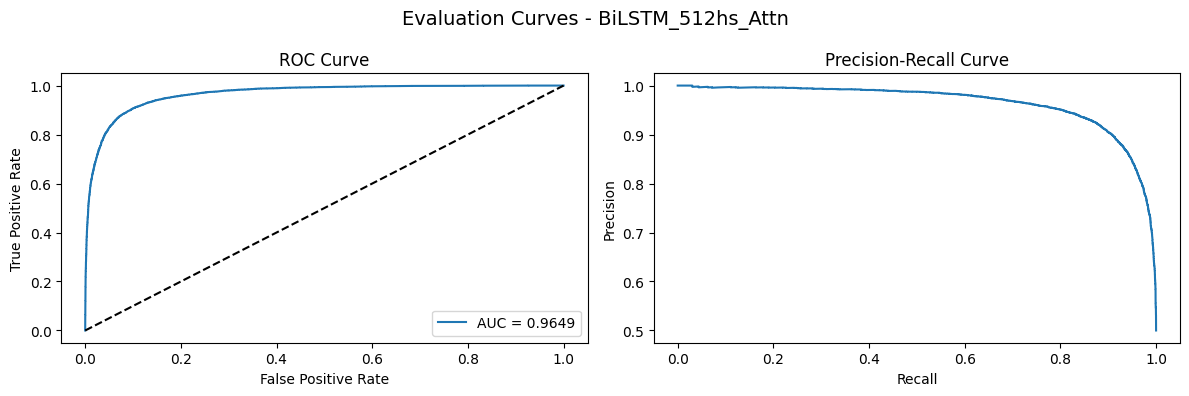

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

for model_name, res in results.items():
    y_true = res["y_true"]
    y_pred = res["y_pred"]
    y_prob = res["y_prob"]

    # ---- Metrics ----
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"\n🔹 {model_name} 🔹")
    print(f"Accuracy: {acc:.4f}, F1 (weighted): {f1:.4f}")
    print(classification_report(y_true, y_pred))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    class_names=[str(c) for c in np.unique(y_true)],
                                    show_normed=False,
                                    cmap="Blues")
    ax.set_title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ---- ROC & PR Curves ----
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Evaluation Curves - {model_name}", fontsize=14)

    # ROC Curve
    axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()

    # PR Curve
    axes[1].plot(rec, prec)
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")

    plt.tight_layout()
    plt.show()
